# Cobalt Repository Social Network Analysis

This notebook analyzes all user activity on the icebreakerlabs/cobalt repository using social network analysis to understand team collaboration patterns and engineering metrics.

## Features:
- Discovers all contributors to the repository
- Collects GitHub activity data (issues, PRs, comments, reviews, discussions)
- Performs comprehensive social network analysis
- Visualizes collaboration patterns and team dynamics
- Exports data to CSV for further analysis

In [76]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import os
import datetime
import subprocess
from typing import List, Dict, Any
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## Configuration

Set your GitHub token and analysis parameters here.

In [77]:
# Configuration
GITHUB_TOKEN = os.environ.get('GITHUB_TOKEN')
REPO_OWNER = 'icebreakerlabs'
REPO_NAME = 'cobalt'

# Analysis period (adjustable)
DAYS_BACK = 30  # Change this to analyze different time periods
since_date = (datetime.datetime.now() - datetime.timedelta(days=DAYS_BACK)).strftime('%Y-%m-%d')
until_date = datetime.datetime.now().strftime('%Y-%m-%d')

print(f"Analyzing activity from {since_date} to {until_date}")
print(f"Repository: {REPO_OWNER}/{REPO_NAME}")

Analyzing activity from 2025-05-28 to 2025-06-27
Repository: icebreakerlabs/cobalt


## Step 1: Discover All Contributors

First, we'll use the GitHub API to discover all users who have contributed to the repository.

In [78]:
def get_repo_contributors(owner: str, repo: str, token: str) -> List[str]:
    """Get all contributors to a repository"""
    headers = {
        'Authorization': f'token {token}',
        'Accept': 'application/vnd.github.v3+json'
    }
    
    url = f'https://api.github.com/repos/{owner}/{repo}/contributors'
    contributors = []
    
    while url:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            contributors.extend([user['login'] for user in data])
            
            # Check for next page
            if 'next' in response.links:
                url = response.links['next']['url']
            else:
                url = None
        else:
            print(f"Error fetching contributors: {response.status_code}")
            break
    
    return contributors

# Get contributors
contributors = get_repo_contributors(REPO_OWNER, REPO_NAME, GITHUB_TOKEN)
print(f"Found {len(contributors)} contributors:")
for contributor in contributors:
    print(f"  - {contributor}")

Found 12 contributors:
  - eliperelman
  - web3pm
  - tayyabmh
  - alan-icebreaker
  - jdille
  - sinasab
  - jack-icebreaker
  - tribixbite
  - james-dean1
  - devin-ai-integration[bot]
  - esteez25
  - rolo-icebreaker


## Step 2: Generate Repository Configuration

Create a repos.json file with all contributors for data collection.

In [79]:
def create_repos_config(contributors: List[str], owner: str, repo: str) -> str:
    """Create repos.json configuration for all contributors"""
    config = []
    for contributor in contributors:
        config.append({
            "username": contributor,
            "owner": owner,
            "repo": repo
        })
    
    # Get the project root directory (works in both script and notebook)
    try:
        # For script execution
        project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    except NameError:
        # For notebook execution - go up from current working directory
        project_root = os.path.dirname(os.getcwd())
    
    config_path = os.path.join(project_root, f"data/cobalt_{repo}_repos.json")
    os.makedirs(os.path.dirname(config_path), exist_ok=True)
    
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    
    return config_path

# Create configuration file
config_path = create_repos_config(contributors, REPO_OWNER, REPO_NAME)
print(f"Created configuration file: {config_path}")

Created configuration file: /Users/charlie/Desktop/icebreaker/gh-graph-explorer/data/cobalt_cobalt_repos.json


## Step 3: Collect GitHub Activity Data

Use the existing tool to collect activity data for all contributors.

In [80]:
def collect_github_data(config_path: str, since_date: str, until_date: str, repo_name: str) -> str:
    """Collect GitHub data using the existing tool"""
    output_file = f"data/cobalt_{repo_name}_activity.csv"
    
    # Get the project root directory (works in both script and notebook)
    try:
        # For script execution
        project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    except NameError:
        # For notebook execution - go up from current working directory
        project_root = os.path.dirname(os.getcwd())
    
    cmd = [
        "uv", "run", os.path.join(project_root, "main.py"), "collect",
        "--repos", os.path.join(project_root, config_path),
        "--output", "csv",
        "--output-file", os.path.join(project_root, output_file),
        "--since-iso", since_date,
        "--until-iso", until_date
    ]
    
    print("Collecting GitHub activity data...")
    print(f"Running command from: {project_root}")
    result = subprocess.run(cmd, capture_output=True, text=True, cwd=project_root)
    
    if result.returncode == 0:
        print(f"Data collected successfully: {output_file}")
        return output_file
    else:
        print(f"Error collecting data: {result.stderr}")
        return None

# Collect data
data_file = collect_github_data(config_path, since_date, until_date, REPO_NAME)

Running command from: /Users/charlie/Desktop/icebreaker/gh-graph-explorer
Data collected successfully: data/cobalt_cobalt_activity.csv


## Step 4: Load and Prepare Data

Load the collected data and prepare it for analysis.

In [81]:
def load_and_prepare_data(file_path: str) -> pd.DataFrame:
    """Load and prepare the collected data"""
    # If file_path is relative, make it absolute from project root
    if not os.path.isabs(file_path):
        try:
            # For script execution
            project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
        except NameError:
            # For notebook execution - go up from current working directory
            project_root = os.path.dirname(os.getcwd())
        file_path = os.path.join(project_root, file_path)
    
    if not os.path.exists(file_path):
        print(f"Data file not found: {file_path}")
        return pd.DataFrame()
    
    df = pd.read_csv(file_path)
    
    # Clean and prepare data
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    df = df[df['created_at'].notnull()]
    df['title'] = df['title'].fillna('[No Title]')
    
    # Remove duplicates
    df.drop_duplicates(inplace=True)
    
    print(f"Loaded {len(df)} activity records")
    print(f"Date range: {df['created_at'].min()} to {df['created_at'].max()}")
    print(f"Unique users: {df['source'].nunique()}")
    print(f"Activity types: {df['type'].value_counts().to_dict()}")
    
    return df

# Load data
if data_file:
    df = load_and_prepare_data(data_file)
else:
    print("No data file available. Please check the data collection step.")
    df = pd.DataFrame()

Loaded 119 activity records
Date range: 2025-04-28 19:03:54+00:00 to 2025-06-27 15:48:35+00:00
Unique users: 9
Activity types: {'pr_created': 57, 'issue_created': 19, 'issue_mentioned': 16, 'issue_comment': 9, 'pr_review_approved': 8, 'issue_comment_mentioned': 8, 'pr_review_commented': 1, 'pr_comment_mentioned': 1}


## Step 5: Build Social Network Graph

Create a NetworkX graph from the activity data.

In [82]:
def build_social_network(df: pd.DataFrame) -> nx.Graph:
    """Build a social network graph from activity data"""
    if df.empty:
        return nx.Graph()
    
    # Create graph from edges
    G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr=['type', 'created_at', 'title'])
    
    # Add node attributes
    for node in G.nodes():
        # Node activity metrics
        node_edges = list(G.edges(node, data=True))
        G.nodes[node]['activity_count'] = len(node_edges)
        G.nodes[node]['first_activity'] = min([edge[2]['created_at'] for edge in node_edges]) if node_edges else None
        G.nodes[node]['last_activity'] = max([edge[2]['created_at'] for edge in node_edges]) if node_edges else None
        
        # Activity type distribution
        activity_types = [edge[2]['type'] for edge in node_edges]
        G.nodes[node]['activity_types'] = dict(Counter(activity_types))
    
    print(f"Built network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    return G

# Build network
if not df.empty:
    G = build_social_network(df)
else:
    G = nx.Graph()

Built network with 87 nodes and 105 edges


## Step 6: Calculate Social Network Analysis Metrics

Compute comprehensive SNA metrics for all nodes.

In [83]:
def calculate_sna_metrics(G):
    """Calculate comprehensive SNA metrics for all users"""
    metrics = {}
    
    # Handle eigenvector centrality for disconnected graphs
    try:
        eigenvector_cent = nx.eigenvector_centrality(G, max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        eigenvector_cent = {node: 0 for node in G.nodes()}
    except nx.NetworkXError:
        eigenvector_cent = {node: 0 for node in G.nodes()}
    
    # Handle eccentricity for disconnected graphs
    eccentricity_dict = {}
    try:
        # Try to compute eccentricity for the whole graph
        eccentricity_dict = nx.eccentricity(G)
    except nx.NetworkXError:
        # If graph is disconnected, compute eccentricity for each connected component
        for component in nx.connected_components(G):
            if len(component) > 1:  # Only compute for components with multiple nodes
                subgraph = G.subgraph(component)
                try:
                    comp_eccentricity = nx.eccentricity(subgraph)
                    eccentricity_dict.update(comp_eccentricity)
                except nx.NetworkXError:
                    # If still fails, set eccentricity to 0 for these nodes
                    for node in component:
                        eccentricity_dict[node] = 0
            else:
                # Single node components have eccentricity 0
                for node in component:
                    eccentricity_dict[node] = 0
    
    for node in G.nodes():
        metrics[node] = {
            # Basic metrics
            'degree': G.degree(node),
            'activity_count': G.nodes[node]['activity_count'],
            
            # Centrality measures
            'degree_centrality': nx.degree_centrality(G).get(node, 0),
            'betweenness_centrality': nx.betweenness_centrality(G).get(node, 0),
            'closeness_centrality': nx.closeness_centrality(G).get(node, 0),
            'eigenvector_centrality': eigenvector_cent.get(node, 0),
            'pagerank': nx.pagerank(G).get(node, 0),
            
            # Clustering and connectivity
            'clustering_coefficient': nx.clustering(G, node),
            'local_efficiency': nx.local_efficiency(G) if G.number_of_nodes() > 1 else 0,
            
            # Network position
            'eccentricity': eccentricity_dict.get(node, 0),
            'average_neighbor_degree': nx.average_neighbor_degree(G).get(node, 0),
            
            # Activity timing
            'first_activity': G.nodes[node]['first_activity'],
            'last_activity': G.nodes[node]['last_activity'],
        }
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
    metrics_df.reset_index(inplace=True)
    metrics_df.rename(columns={'index': 'user'}, inplace=True)
    
    return metrics_df

# Calculate metrics
if len(G.nodes()) > 0:
    sna_metrics = calculate_sna_metrics(G)
    print(f"Calculated SNA metrics for {len(sna_metrics)} users")
    
    # Display metrics
    print("\nTop 10 users by degree centrality:")
    print(sna_metrics.nlargest(10, 'degree_centrality')[['user', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality']])
    
    print("\nTop 10 users by betweenness centrality:")
    print(sna_metrics.nlargest(10, 'betweenness_centrality')[['user', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality']])
    
    print("\nTop 10 users by closeness centrality:")
    print(sna_metrics.nlargest(10, 'closeness_centrality')[['user', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality']])
else:
    print("No nodes in the graph to analyze")
    sna_metrics = pd.DataFrame()

Calculated SNA metrics for 87 users

Top 10 users by degree centrality:
                                                 user  degree_centrality  \
26                                             web3pm           0.476744   
0                                         eliperelman           0.302326   
28                                             claude           0.220930   
75                                             jdille           0.104651   
66                                           tayyabmh           0.069767   
32  https://github.com/icebreakerlabs/cobalt/issue...           0.034884   
65  https://github.com/icebreakerlabs/cobalt/pull/...           0.034884   
5   https://github.com/icebreakerlabs/cobalt/pull/...           0.023256   
21  https://github.com/icebreakerlabs/cobalt/pull/...           0.023256   
22  https://github.com/icebreakerlabs/cobalt/pull/...           0.023256   

    betweenness_centrality  closeness_centrality  
26                0.532540              

## Step 7: Visualize Network Metrics

Create comprehensive visualizations of the social network analysis results.

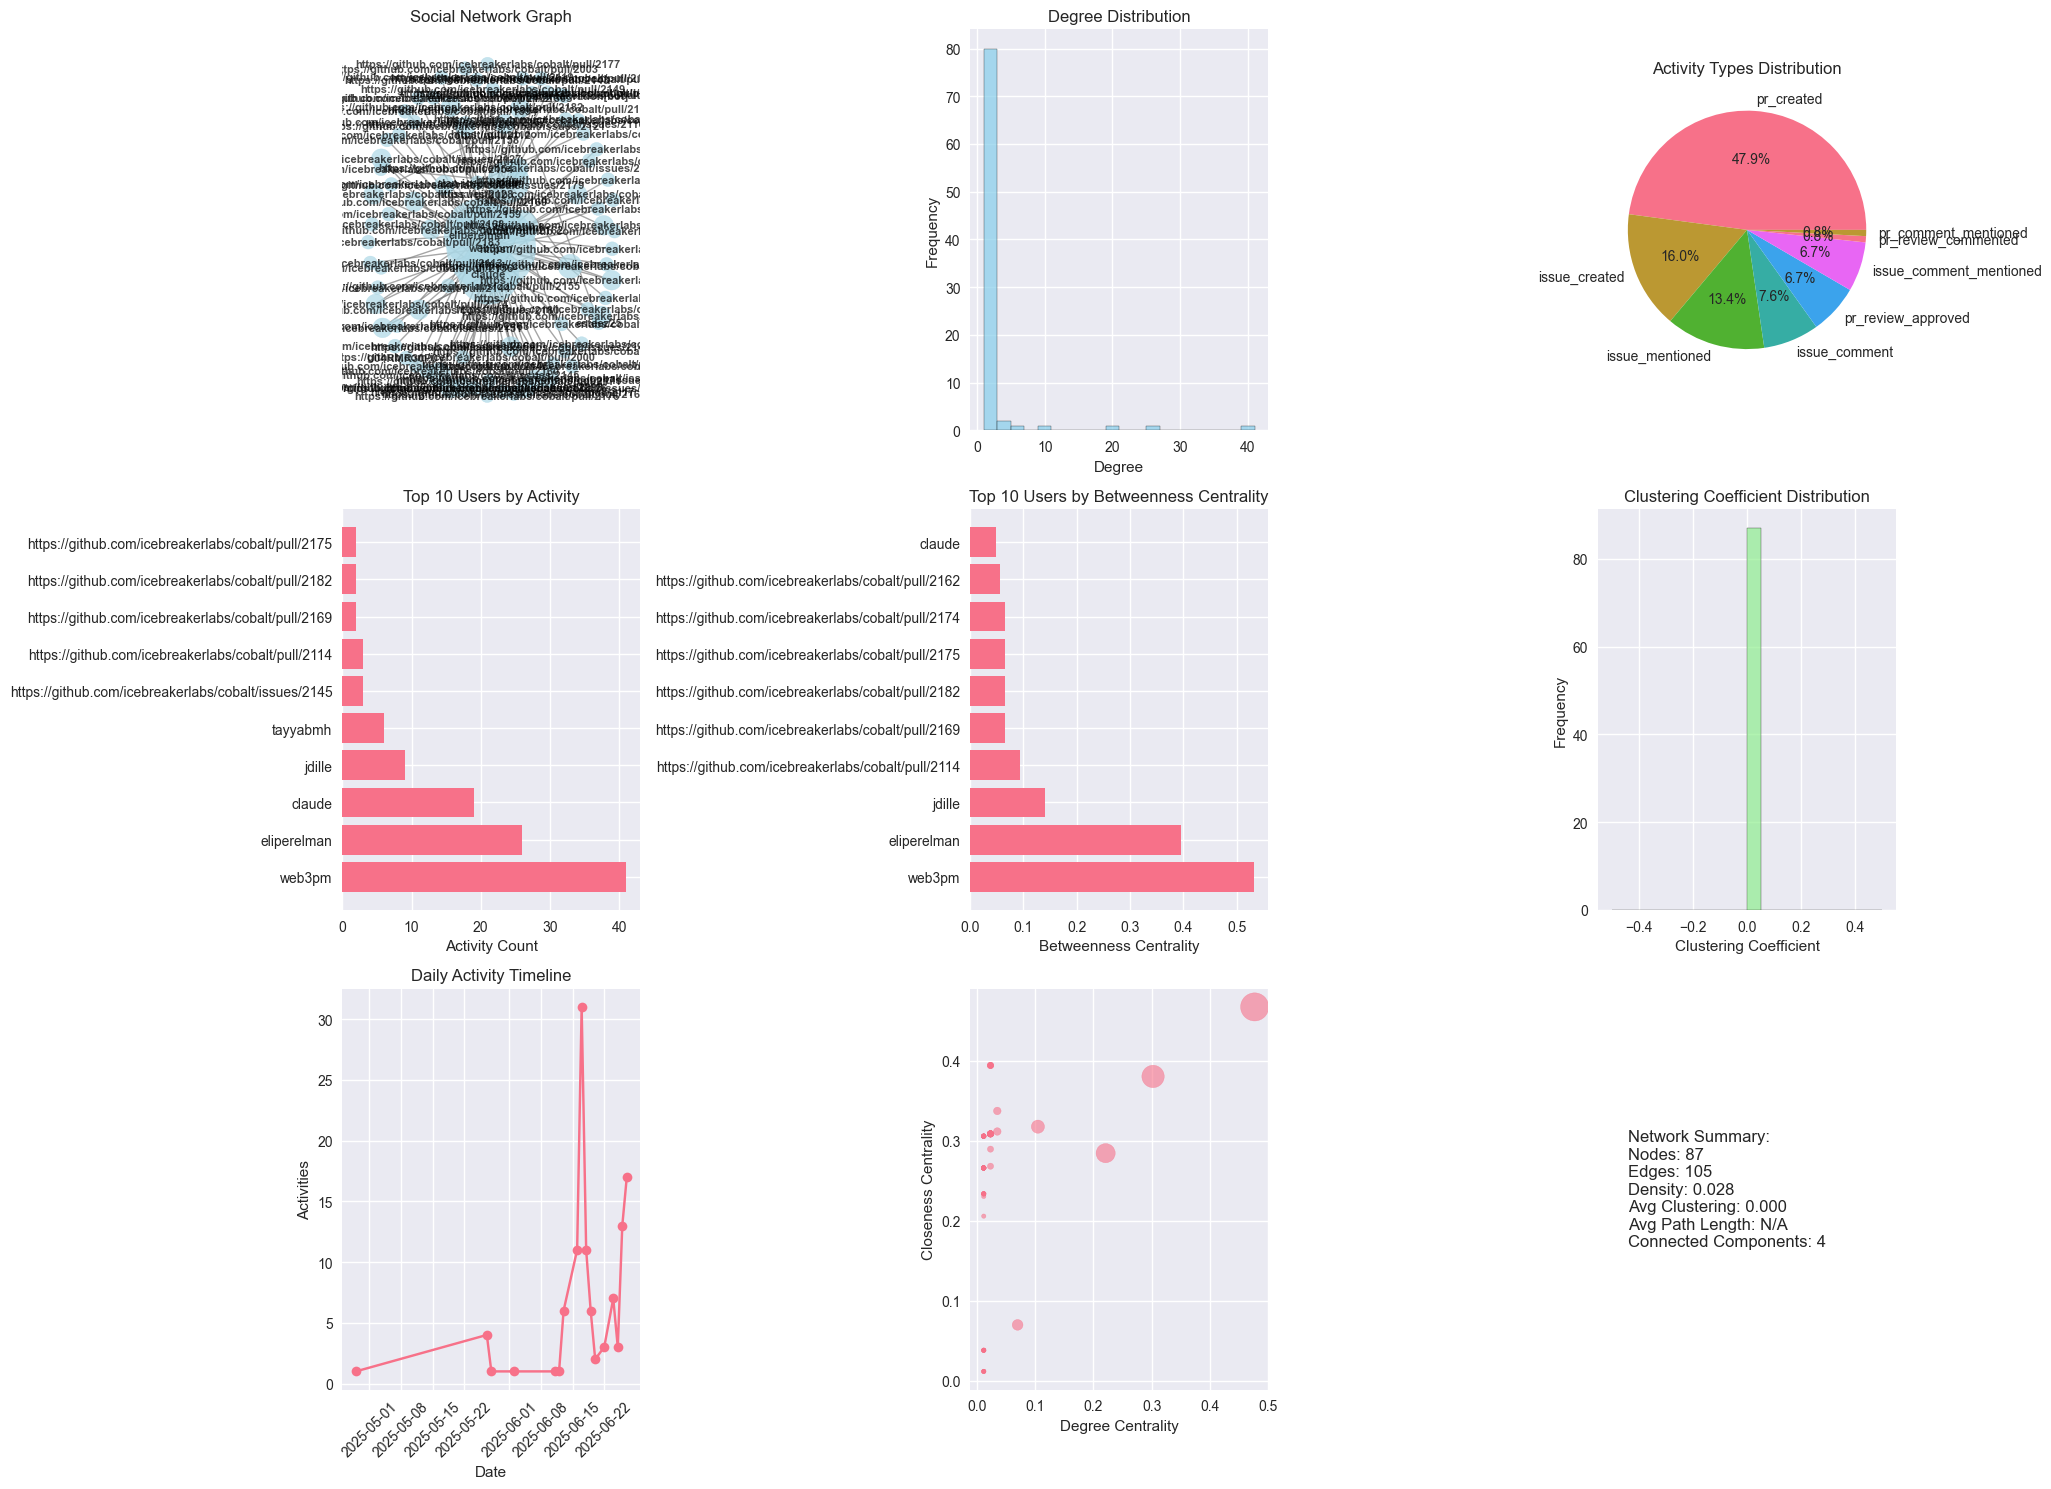

In [84]:
def create_network_visualizations(G: nx.Graph, sna_metrics: pd.DataFrame, df: pd.DataFrame):
    """Create comprehensive network visualizations"""
    if len(G.nodes()) == 0 or sna_metrics.empty:
        print("No data available for visualization")
        return
    
    # Create a comprehensive visualization dashboard
    plt.figure(figsize=(20, 15))
    
    # 1. Network Graph
    plt.subplot(3, 3, 1)
    pos = nx.spring_layout(G, k=1, iterations=50)
    node_sizes = [sna_metrics[sna_metrics['user'] == node]['activity_count'].iloc[0] * 100 if node in sna_metrics['user'].values else 100 for node in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='lightblue', 
            font_size=8, font_weight='bold', edge_color='gray', alpha=0.7)
    plt.title('Social Network Graph')
    
    # 2. Degree Distribution
    plt.subplot(3, 3, 2)
    degrees = [G.degree(node) for node in G.nodes()]
    plt.hist(degrees, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Degree Distribution')
    
    # 3. Activity Types Distribution (if available in raw data)
    plt.subplot(3, 3, 3)
    if not df.empty:
        activity_counts = df['type'].value_counts()
        plt.pie(activity_counts.values, labels=activity_counts.index, autopct='%1.1f%%')
        plt.title('Activity Types Distribution')
    else:
        plt.text(0.5, 0.5, 'No activity data available', ha='center', va='center')
        plt.title('Activity Types Distribution')
    
    # 4. Top Users by Activity Count
    plt.subplot(3, 3, 4)
    top_users = sna_metrics.nlargest(10, 'activity_count')
    plt.barh(top_users['user'], top_users['activity_count'])
    plt.xlabel('Activity Count')
    plt.title('Top 10 Users by Activity')
    
    # 5. Centrality Comparison
    plt.subplot(3, 3, 5)
    top_central = sna_metrics.nlargest(10, 'betweenness_centrality')
    plt.barh(top_central['user'], top_central['betweenness_centrality'])
    plt.xlabel('Betweenness Centrality')
    plt.title('Top 10 Users by Betweenness Centrality')
    
    # 6. Clustering Coefficient Distribution
    plt.subplot(3, 3, 6)
    clustering_coeffs = sna_metrics['clustering_coefficient'].dropna()
    if len(clustering_coeffs) > 0:
        plt.hist(clustering_coeffs, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
        plt.xlabel('Clustering Coefficient')
        plt.ylabel('Frequency')
        plt.title('Clustering Coefficient Distribution')
    else:
        plt.text(0.5, 0.5, 'No clustering data available', ha='center', va='center')
        plt.title('Clustering Coefficient Distribution')
    
    # 7. Activity Timeline
    plt.subplot(3, 3, 7)
    if not df.empty:
        df['date'] = pd.to_datetime(df['created_at']).dt.date
        daily_activity = df.groupby('date').size()
        plt.plot(daily_activity.index, daily_activity.values, marker='o')
        plt.xlabel('Date')
        plt.ylabel('Activities')
        plt.title('Daily Activity Timeline')
        plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, 'No timeline data available', ha='center', va='center')
        plt.title('Daily Activity Timeline')
    
    # 8. Centrality Scatter Plot
    plt.subplot(3, 3, 8)
    plt.scatter(sna_metrics['degree_centrality'], sna_metrics['closeness_centrality'], 
               alpha=0.6, s=sna_metrics['activity_count']*10)
    plt.xlabel('Degree Centrality')
    plt.ylabel('Closeness Centrality')
    
    # 9. Network Summary Statistics
    plt.subplot(3, 3, 9)
    plt.axis('off')
    stats_text = f"""
Network Summary:
Nodes: {G.number_of_nodes()}
Edges: {G.number_of_edges()}
Density: {nx.density(G):.3f}
Avg Clustering: {nx.average_clustering(G):.3f}
Avg Path Length: {nx.average_shortest_path_length(G) if nx.is_connected(G) else 'N/A'}
Connected Components: {nx.number_connected_components(G)}
    """
    plt.text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

# Create visualizations
if len(G.nodes()) > 0 and not sna_metrics.empty:
    create_network_visualizations(G, sna_metrics, df)
else:
    print("No data available for visualization")


In [ ]:
def calculate_sna_metrics(G: nx.Graph) -> pd.DataFrame:
    """Calculate comprehensive social network analysis metrics"""
    if G.number_of_nodes() == 0:
        return pd.DataFrame()
    
    metrics = {}
    
    # Calculate centrality measures that work with disconnected graphs
    try:
        eigenvector_cent = nx.eigenvector_centrality_numpy(G)
    except nx.AmbiguousSolution:
        # For disconnected graphs, use a different approach
        eigenvector_cent = {}
        for node in G.nodes():
            # Calculate eigenvector centrality for each connected component
            component = nx.node_connected_component(G, node)
            if len(component) > 1:
                subgraph = G.subgraph(component)
                try:
                    sub_cent = nx.eigenvector_centrality_numpy(subgraph)
                    eigenvector_cent[node] = sub_cent.get(node, 0)
                except:
                    eigenvector_cent[node] = 0
            else:
                eigenvector_cent[node] = 0
    
    for node in G.nodes():
        metrics[node] = {
            # Basic metrics
            'degree': G.degree(node),
            'activity_count': G.nodes[node]['activity_count'],
            
            # Centrality measures
            'betweenness_centrality': nx.betweenness_centrality(G).get(node, 0),
            'closeness_centrality': nx.closeness_centrality(G).get(node, 0),
            'eigenvector_centrality': eigenvector_cent.get(node, 0),
            'pagerank': nx.pagerank(G).get(node, 0),
            
            # Clustering and connectivity
            'clustering_coefficient': nx.clustering(G, node),
            'local_efficiency': nx.local_efficiency(G) if G.number_of_nodes() > 1 else 0,
            
            # Network position
            'eccentricity': nx.eccentricity(G).get(node, 0),
            'average_neighbor_degree': nx.average_neighbor_degree(G).get(node, 0),
            
            # Activity timing
            'first_activity': G.nodes[node]['first_activity'],
            'last_activity': G.nodes[node]['last_activity'],
        }
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
    metrics_df.index.name = 'user'
    metrics_df.reset_index(inplace=True)
    
    # Add activity type breakdown
    activity_types = []
    for node in G.nodes():
        types = G.nodes[node]['activity_types']
        activity_types.append({
            'user': node,
            'issues_created': types.get('issue_created', 0),
            'prs_created': types.get('pr_created', 0),
            'pr_reviews': sum(1 for t in types.keys() if 'pr_review' in t),
            'comments': sum(1 for t in types.keys() if 'comment' in t),
            'discussions': sum(1 for t in types.keys() if 'discussion' in t),
            'mentions': sum(1 for t in types.keys() if 'mentioned' in t)
        })
    
    activity_df = pd.DataFrame(activity_types)
    metrics_df = metrics_df.merge(activity_df, on='user', how='left')
    
    return metrics_df

# Calculate metrics
if not G.is_empty():
    sna_metrics = calculate_sna_metrics(G)
    print(f"Calculated SNA metrics for {len(sna_metrics)} users")
    print("\nTop 5 users by activity count:")
    print(sna_metrics.nlargest(5, 'activity_count')[['user', 'activity_count', 'degree', 'betweenness_centrality']])
else:
    sna_metrics = pd.DataFrame()

AttributeError: 'Graph' object has no attribute 'is_empty'

## Step 8: Export Data

Export all analysis results to CSV files for further analysis.

In [85]:
def export_data(df: pd.DataFrame, sna_metrics: pd.DataFrame, G: nx.Graph):
    """Export all data to CSV files"""
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Export raw activity data
    if not df.empty:
        df.to_csv(f'data/cobalt_{REPO_NAME}_raw_activity_{timestamp}.csv', index=False)
        print(f"Exported raw activity data: cobalt_{REPO_NAME}_raw_activity_{timestamp}.csv")
    
    # Export SNA metrics
    if not sna_metrics.empty:
        sna_metrics.to_csv(f'data/cobalt_{REPO_NAME}_sna_metrics_{timestamp}.csv', index=False)
        print(f"Exported SNA metrics: cobalt_{REPO_NAME}_sna_metrics_{timestamp}.csv")
    
    # Export network edges
    if len(G.nodes()) > 0:
        edges_df = pd.DataFrame(list(G.edges(data=True)), columns=['source', 'target', 'attributes'])
        edges_df['type'] = edges_df['attributes'].apply(lambda x: x.get('type', ''))
        edges_df['created_at'] = edges_df['attributes'].apply(lambda x: x.get('created_at', ''))
        edges_df['title'] = edges_df['attributes'].apply(lambda x: x.get('title', ''))
        edges_df = edges_df.drop('attributes', axis=1)
        edges_df.to_csv(f'data/cobalt_{REPO_NAME}_network_edges_{timestamp}.csv', index=False)
        print(f"Exported network edges: cobalt_{REPO_NAME}_network_edges_{timestamp}.csv")
    
    # Export summary report
    summary = {
        'analysis_date': datetime.datetime.now().isoformat(),
        'repository': f'{REPO_OWNER}/{REPO_NAME}',
        'analysis_period_days': DAYS_BACK,
        'since_date': since_date,
        'until_date': until_date,
        'total_contributors': len(contributors),
        'total_activities': len(df) if not df.empty else 0,
        'network_nodes': G.number_of_nodes() if len(G.nodes()) > 0 else 0,
        'network_edges': G.number_of_edges() if len(G.nodes()) > 0 else 0,
        'network_density': nx.density(G) if len(G.nodes()) > 0 else 0,
        'avg_clustering': nx.average_clustering(G) if len(G.nodes()) > 0 else 0,
        'connected_components': nx.number_connected_components(G) if len(G.nodes()) > 0 else 0
    }
    
    summary_df = pd.DataFrame([summary])
    summary_df.to_csv(f'data/cobalt_{REPO_NAME}_analysis_summary_{timestamp}.csv', index=False)
    print(f"Exported analysis summary: cobalt_{REPO_NAME}_analysis_summary_{timestamp}.csv")

# Export all data
export_data(df, sna_metrics, G)

Exported raw activity data: cobalt_cobalt_raw_activity_20250627_144053.csv
Exported SNA metrics: cobalt_cobalt_sna_metrics_20250627_144053.csv
Exported network edges: cobalt_cobalt_network_edges_20250627_144053.csv
Exported analysis summary: cobalt_cobalt_analysis_summary_20250627_144053.csv


## Step 9: Key Insights and Recommendations

Generate insights and recommendations based on the analysis.

In [86]:
def generate_insights(sna_metrics: pd.DataFrame, G: nx.Graph, df: pd.DataFrame):
    """Generate insights and recommendations from the analysis"""
    if sna_metrics.empty or len(G.nodes()) == 0:
        print("No data available for insights")
        return
    
    print("=" * 60)
    print("KEY INSIGHTS AND RECOMMENDATIONS")
    print("=" * 60)
    
    # Top contributors
    top_contributors = sna_metrics.nlargest(3, 'activity_count')
    print(f"\n🏆 TOP CONTRIBUTORS:")
    for _, user in top_contributors.iterrows():
        print(f"  • {user['user']}: {user['activity_count']} activities")
    
    # Most central users
    most_central = sna_metrics.nlargest(3, 'betweenness_centrality')
    print(f"\n🔗 MOST CENTRAL USERS (Information Brokers):")
    for _, user in most_central.iterrows():
        print(f"  • {user['user']}: {user['betweenness_centrality']:.3f} betweenness centrality")
    
    # Network health indicators
    density = nx.density(G)
    avg_clustering = nx.average_clustering(G)
    components = nx.number_connected_components(G)
    
    print(f"\n📊 NETWORK HEALTH INDICATORS:")
    print(f"  • Network Density: {density:.3f} ({'High' if density > 0.1 else 'Medium' if density > 0.05 else 'Low'} collaboration)")
    print(f"  • Average Clustering: {avg_clustering:.3f} ({'Strong' if avg_clustering > 0.3 else 'Moderate' if avg_clustering > 0.1 else 'Weak'} community structure)")
    print(f"  • Connected Components: {components} ({'Good' if components == 1 else 'Fragmented'} network)")
    
    # Activity patterns
    if not df.empty:
        activity_by_type = df['type'].value_counts()
        print(f"\n📈 ACTIVITY PATTERNS:")
        for activity_type, count in activity_by_type.head().items():
            print(f"  • {activity_type}: {count} activities")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    
    if density < 0.05:
        print("  • Consider initiatives to increase cross-team collaboration")
    
    if components > 1:
        print("  • Identify and bridge isolated team members or groups")
    
    if avg_clustering < 0.1:
        print("  • Encourage more focused team interactions and discussions")
    
    # Identify potential bottlenecks
    high_betweenness = sna_metrics[sna_metrics['betweenness_centrality'] > sna_metrics['betweenness_centrality'].quantile(0.9)]
    if len(high_betweenness) > 0:
        print(f"  • Monitor high-centrality users for potential bottlenecks: {', '.join(high_betweenness['user'].tolist())}")
    
    print("\n" + "=" * 60)

# Generate insights
if not sna_metrics.empty and len(G.nodes()) > 0:
    generate_insights(sna_metrics, G, df)

KEY INSIGHTS AND RECOMMENDATIONS

🏆 TOP CONTRIBUTORS:
  • web3pm: 41 activities
  • eliperelman: 26 activities
  • claude: 19 activities

🔗 MOST CENTRAL USERS (Information Brokers):
  • web3pm: 0.533 betweenness centrality
  • eliperelman: 0.396 betweenness centrality
  • jdille: 0.141 betweenness centrality

📊 NETWORK HEALTH INDICATORS:
  • Network Density: 0.028 (Low collaboration)
  • Average Clustering: 0.000 (Weak community structure)
  • Connected Components: 4 (Fragmented network)

📈 ACTIVITY PATTERNS:
  • pr_created: 57 activities
  • issue_created: 19 activities
  • issue_mentioned: 16 activities
  • issue_comment: 9 activities
  • pr_review_approved: 8 activities

💡 RECOMMENDATIONS:
  • Consider initiatives to increase cross-team collaboration
  • Identify and bridge isolated team members or groups
  • Encourage more focused team interactions and discussions
  • Monitor high-centrality users for potential bottlenecks: eliperelman, https://github.com/icebreakerlabs/cobalt/pull